In [13]:
import os
import re 
# !pip install pandas
# !pip install watermark
# ! pip install seaborn
# !pip install numba
# !pip install numba
from numba import jit
import pandas as pd
import numpy as np 
# pip install Cython 

import seaborn as sns
import watermark
import random 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = 'all'
%load_ext watermark
%watermark
%watermark --iversion

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2021-05-04T23:30:21.419754+08:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 11, GenuineIntel
CPU cores   : 8
Architecture: 64bit

watermark : 2.2.0
matplotlib: 3.3.4
pandas    : 1.2.4
re        : 2.2.1
numpy     : 1.20.1
seaborn   : 0.11.1



In [14]:
left=3
right=6 
signal_num = left+right
bases="ACGT"
lower_bases="acgt"
noknown_bases="nksrywmbv"

priorP=pd.read_csv("output/donor_prior_probability_(P+).csv",index_col=[0])
priorN=pd.read_csv("output/prior_probability_(P-).csv",index_col=[0])
conditionalP=pd.read_csv("output/donor_conditionalDf_probability(P+).csv",index_col=[0])
conditionalN=pd.read_csv("output/conditionalDf_probability(P-).csv",index_col=[0])
all_donor_signal=pd.read_csv("output/Train_donor_signal_info.csv")
# priorN
conditionalP
# conditionalN
# all_donor_signal
# 读取donor片段
def read_donors(filename):
    donors = []
    f = open(filename)
    lines = f.readlines()
    for line in lines:
        donors.append(line.strip('\n'))
    f.close()
    print('read donors successful!')
    return donors
donor_strs=read_donors("output/Train_donor_signal_str.txt")
test_donor_strs=read_donors("output/Test_donor_signal_str.txt")
test_nondonor_strs=read_donors("output/Train_nondonor_signal_str.txt")

read donors successful!
read donors successful!
read donors successful!


In [15]:
priorP.iloc[0]
priorP.iloc[0][1]
priorP.iloc[0,1]

0.3637127257454851

In [16]:
donor_strs[1]

'ttcgtaagt'

In [17]:
priorP = np.array(priorP)
priorN = np.array(priorN)
conditionalP = np.array(conditionalP)
conditionalN = np.array(conditionalN)

In [18]:
def log_c(num,ex_mini=10e-9):
    if num == 0:
        return np.log(ex_mini)
    else:
        return np.log(num)

def process_donors(donors):
    char_to_int = {c:i for i, c in enumerate(lower_bases)}
    integer_encoded = [char_to_int[char] for char in donors]
    return np.array(integer_encoded)

# @jit(nopython=True)
# def WAM_formula():
    
def cal_WAM(seq, priorA=priorP[0], priorB=priorN[0], conditionalA=conditionalP, conditionalB=conditionalN):
#     print(seq)
    # 计算得分
    seq = process_donors(seq)
    S = np.log(priorA[seq[0]]) - np.log(priorB[seq[0]])
    
    for i in range(signal_num-1):
            S += log_c(conditionalA[i,seq[i]*4+seq[i+1]]) - log_c(conditionalB[i,seq[i]*4+seq[i+1]])
    return S


donor_strs = tqdm(donor_strs, desc='Calculating Donor signal score:')
scores=list(map(cal_WAM,donor_strs))
len(scores)
type(scores)
# scores

Calculating Donor signal score::   0%|          | 0/2381 [00:00<?, ?it/s]

list

In [20]:
s1 = pd.Series(scores)
print(s1.describe())

count    2381.000000
mean        5.778167
std         1.511147
min        -2.048024
25%         4.790803
50%         5.708973
75%         6.988869
max         8.844265
dtype: float64


In [22]:
s1.describe().to_csv("output/donor_score_describe.csv")

In [23]:
test_nondonor_strs = tqdm(test_nondonor_strs, desc='Calculating Non scores:')
non_scores=list(map(cal_WAM,test_nondonor_strs))

Calculating Conditional Probability::   0%|          | 0/4922041 [00:00<?, ?it/s]

In [94]:
s2 = pd.Series(non_scores)
print(s2.describe())


count    4.922041e+06
mean    -4.375146e+01
std      1.330738e+01
min     -5.865374e+01
25%     -5.385907e+01
50%     -5.042152e+01
75%     -3.609570e+01
max      8.844265e+00
dtype: float64


In [95]:
s2.describe().to_csv("output/nondonor_score_describe.csv")

In [43]:
# sns.set()
# ax = sns.distplot(scores)
# distplot不能用了。

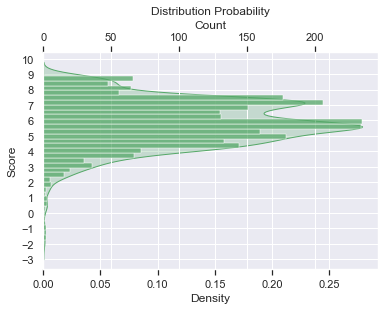

In [68]:
ax = sns.kdeplot(y=scores,shade=True,color="g",bw_adjust=1,cut=3)
ax.set_xlabel("Density");
ax.set_ylabel("Score");
ax2 = plt.twiny()
ax2 = sns.histplot(y=scores,ax=ax2,color="g")
ax2.set_title('Distribution Probability')
ax2.set(xlabel='Count')
ax2.set_yticks(np.linspace(-4,10,15))
plt.show();
fig = ax.get_figure()
fig.savefig('output/Distribution_Probability_x-left{left}-right{right}.png',dpi = 400) #路径+文件名


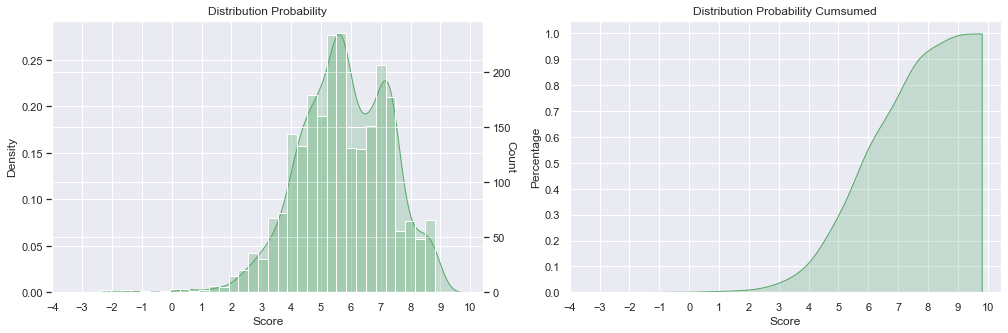

In [65]:
def draw_distribution(scores,name="donor"):
    sns.set(style='darkgrid')
    fig,axes = plt.subplots(1,2,figsize=(17,5))
    ax1 = sns.kdeplot(scores,shade=True,color="g",bw_adjust=1,cut=3,ax=axes[0])
    ax1.set_ylabel('Density')
    ax1.set_xlabel("Score")
    ax2 = axes[0].twinx()
    ax2 = sns.histplot(scores,ax=ax2,color="g",alpha=0.3)
    ax2.set_ylabel('Count',rotation=270)
    axes[0].set_title('Distribution Probability')


    ax3 = sns.kdeplot(scores,shade=True,color="g",bw_adjust=1,cut=3,cumulative=True,ax=axes[1])
    ax3.set_ylabel('Percentage')
    ax3.set_xlabel("Score")
    ax3.set_title('Distribution Probability Cumsumed')
    if name == 'donor':
        axes[0].set_xticks(np.linspace(-4,10,15))
        ax3.set_xticks(np.arange(-4,11,1))
        ax3.set_yticks(np.arange(0,1.1,0.1))
    else:
        pass

    fig.savefig(f'output/Distribution_Probability_{name}.png',dpi = 400) #路径+文件名
draw_distribution(scores)

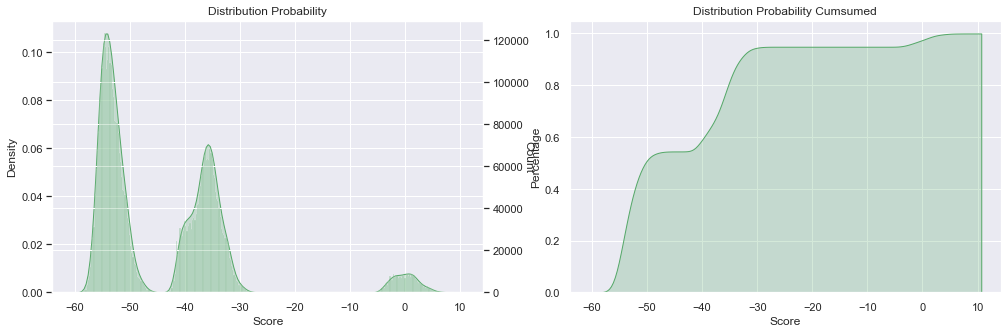

In [66]:
draw_distribution(non_scores,name="nodonor")

考虑到最后一个外显子没有donor site后，分值明显高了很多
下一步目标
- 设定阈值分布，然后统计不同阈值的效果，sp，sn曲线？
- 如果确定输出的那个值会是donor site呢
走起！

In [46]:
testdf=pd.read_csv("output/Test_set_info.csv")
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Path              570 non-null    object
 1   Locus             570 non-null    object
 2   Length            570 non-null    int64 
 3   Exon Num          570 non-null    int64 
 4   Exon Location     570 non-null    object
 5   Donor Site        570 non-null    object
 6   Acceptor Site     570 non-null    object
 7   Donor signals     570 non-null    object
 8   Acceptor signals  570 non-null    object
 9   Seq               570 non-null    object
dtypes: int64(2), object(8)
memory usage: 44.7+ KB


In [47]:
testdf.head()

,Path,Locus,Length,Exon Num,Exon Location,Donor Site,Acceptor Site,Donor signals,Acceptor signals,Seq
0,Testing Set/ACU08131.TXT,ACU08131,5392,6,"[('521', '641'), ('1066', '1362'), ('1860', '2...","[642, 1363, 2029, 2803, 3798]","[1065, 1859, 2636, 3557, 4130]","['ggggtgagc', 'gtggtaaga', 'taggtgagt', 'gcggt...","['tggcaggcc', 'ccataggta', 'ctctaggta', 'acaca...",ctgggctaaaaggtcccttagcctatttagaaaaatgggccattag...
1,Testing Set/AGGGLINE.TXT,AGGGLINE,7360,3,"[('3066', '3157'), ('3281', '3503'), ('4393', ...","[3158, 3504]","[3280, 4392]","['aaggtaggc', 'agggtgagt']","['tcacaggct', 'caacagctc']",caaggctgctgtcactagcctgtggggcaaggtgaatgtggaagat...
2,Testing Set/AGU04852.TXT,AGU04852,10984,5,"[('3951', '3955'), ('5434', '5516'), ('5810', ...","[3956, 5517, 5912, 6740]","[5433, 5809, 6664, 7636]","['gaggtgggt', 'caggtcagt', 'acggtaaga', 'caggt...","['ctgcagtgc', 'ttgcagatg', 'ttttaggag', 'tgaca...",gaattcaatactccactttccattctgttcaaaggtcacgtatagt...
3,Testing Set/ALOEGLOBIM.txt,ALOEGLOBIM,1691,3,"[('145', '236'), ('360', '582'), ('1392', '152...","[237, 583]","[359, 1391]","['caggtaagc', 'agggtgagt']","['tcataggct', 'taacagctc']",ccttgaccaatgactttcaagtaccacggaaaacaggggggcagaa...
4,Testing Set/ALOEGLOBIN.txt,ALOEGLOBIN,1691,3,"[('145', '236'), ('360', '582'), ('1392', '152...","[237, 583]","[359, 1391]","['caggtaagc', 'agggtgagt']","['tcataggct', 'taacagctc']",ccttgaccaatgacttttaagtaccacggaaaacaggggggcagaa...


In [48]:
test_donorSite_strs=testdf.loc[:,"Donor Site"] 
test_donor_list = []
for file in test_donorSite_strs:
    str_list = re.findall('\d+',file)
    test_donor_list.append([int(pos)for pos in str_list])
test_seqLength_list=testdf.loc[:,"Length"]
test_signal_list=testdf.loc[:,"Donor signals"]
test_seq_list = testdf.loc[:,"Seq"]
test_locus_list=testdf.loc[:,"Locus"]
file_num=len(test_seqLength_list)
signal_list = []
for file in test_signal_list:
    signal_list.append(re.findall('\'([a-z]+)\'',file))
# type(test_seq_list[0])

In [49]:
test_donor_list[1]

[3158, 3504]

In [50]:
signal_list[1:3:4]

[['aaggtaggc', 'agggtgagt']]

In [51]:

list(map(cal_WAM,signal_list[1]))


[5.65051860294648, 6.8726889762975425]

In [52]:
re.findall('\'([a-z]+)\'',"['ggggtgagc', 'gtggtaaga', 'taggtgagt', 'gcggtaggt', 'caggtaatt']")

['ggggtgagc', 'gtggtaaga', 'taggtgagt', 'gcggtaggt', 'caggtaatt']

In [57]:
Sn_list = []
Sp_list = []
P_list= []
threshold_range = tqdm(np.arange(-4,10,0.5), desc='Threshold Picking:')
df_all_threshold =pd.DataFrame(columns=["Threshold","Predict Sites","Positive Sites",\
                                "Negative Sites","Actual Donor Sites","Predict Count","TP","FP","TN","FN"])
TNs =[]
TPs =[]
FNs =[]
FPs =[]
pattern = re.compile("[^acgt]")
# def predict_file(i):

for threshold in threshold_range:
    files_scores = []
    files_predict_sites = []
    total_count=TP =FP = FN =TN =0
    files_negative_sites = []
    files_positive_sites = []
    TP_counts = []
    FP_counts = []
    FN_counts = []
    TN_counts = []
    predict_counts = []
    files = tqdm(range(file_num), desc='Predicting:')
    for i in files:
        TP_count = 0
        FP_count = 0
        FN_count = 0
        predict_count = 0
        seq= test_seq_list[i]
        seq_length = test_seqLength_list[i]
        scores = []
        predict_sites = []
        positive_sites = []
        negative_sites = []
        for pos in  range(seq_length-signal_num+1):
            signal = seq[pos:pos+signal_num]
            no_known =pattern.search(signal)
            if no_known:
               continue
            else:
                s=cal_WAM(signal)
                predict_count +=1
                if s > threshold:
                    scores.append(s)
                    predict_site= pos+left+1
                    predict_sites.append(predict_site)
                    if predict_site in test_donor_list[i]:
                        TP_count +=1
                        positive_sites.append(predict_site)
                    else:
                        FP_count +=1
                        negative_sites.append(predict_site)
        TP += TP_count
        FP += FP_count
        FN_count = len(test_donor_list[i])-TP_count
        FN += FN_count
        TN_count = predict_count-TP_count-FP_count-FN_count
        total_count +=predict_count
        files_scores.append(scores)
        files_predict_sites.append(predict_sites)
        files_positive_sites.append(positive_sites)
        files_negative_sites.append(negative_sites)
        TP_counts.append(TP_count)
        FP_counts.append(FP_count)
        FN_counts.append(FN_count)
        TN_counts.append(TN_count)
        predict_counts.append(predict_count)
    df_threshold=pd.DataFrame({"Threshold":threshold,"Locus":test_locus_list[0:file_num],"Predict Sites":files_predict_sites,\
      "Positive Sites":files_positive_sites,"Negative Sites":files_negative_sites,"Actual Donor Sites":test_donor_list[0:file_num],\
                  "Predict Num":predict_counts,"Predict Positive Num":np.sum([TP_counts,FP_counts], axis=0),"Predict Negative Num":np.sum([TN_counts,FN_counts], axis=0),"TP":TP_counts,"FP":FP_counts,"TN":TN_counts,"FN":FN_counts})
    df_threshold.to_csv(f"predict/Threshold_{threshold}_file_info.csv",index=None)
    df_all_threshold = pd.concat([df_all_threshold,df_threshold]).reset_index(drop=True)
    TN = total_count-TP-FN-FP
    TPR = TP/(TP+FN)
    TNR = TN / (FP+TN) # 我总算知道为什么sp用的是这个公式，而不是正常的公式了，阈值高于0时，sp会特别大，至少0.9++，所以看不出太大差异
    FPR = 1-TNR
    try:
        P = TP/(TP+FP)
        print(f"When threshold is {threshold:},Sn is: {TPR:.3f},Precision is: {P:.3f},Sp is {TNR:.3f},FPR is {FPR:.3f}")
    except ZeroDivisionError:
        P = None
        print(f"When threshold is {threshold:},Sn is: {TPR:.3f},Precision is: None ,Sp is {TNR:.3f},FPR is {FPR:.3f}") 
    Sn_list.append(TPR)
    Sp_list.append(TNR)
    P_list.append(P)
    TNs.append(TN)
    TPs.append(TP)
    FNs.append(FN)
    FPs.append(FP)
df_threshold.to_csv("predict/Threshold_all_file_info.csv",index=None)
df_all_threshold=pd.DataFrame({"Threshold":list(threshold_range),\
                  "TP":TPs,"FP":FPs,"TN":TNs,"FN":FNs,"Sn":Sn_list,"Sp":Sp_list,"Precision":P_list})

df_all_threshold["FPR"] = 1-df_all_threshold["Sp"]
df_all_threshold["Acc"] = (df_all_threshold["TP"]+df_all_threshold["TN"])/(df_all_threshold["TP"]+df_all_threshold["FP"]+df_all_threshold["TN"]+df_all_threshold["FN"])
df_all_threshold.to_csv("predict/All_Threshold_info.csv",index=None)

Threshold Picking::   0%|          | 0/28 [00:00<?, ?it/s]

Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -4.0,Sn is: 1.000,Precision is: 0.014,Sp is 0.949,FPR is 0.051


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -3.5,Sn is: 1.000,Precision is: 0.014,Sp is 0.951,FPR is 0.049


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -3.0,Sn is: 1.000,Precision is: 0.015,Sp is 0.953,FPR is 0.047


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -2.5,Sn is: 1.000,Precision is: 0.016,Sp is 0.956,FPR is 0.044


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -2.0,Sn is: 1.000,Precision is: 0.018,Sp is 0.960,FPR is 0.040


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -1.5,Sn is: 1.000,Precision is: 0.019,Sp is 0.963,FPR is 0.037


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -1.0,Sn is: 0.999,Precision is: 0.021,Sp is 0.967,FPR is 0.033


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is -0.5,Sn is: 0.999,Precision is: 0.024,Sp is 0.970,FPR is 0.030


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 0.0,Sn is: 0.999,Precision is: 0.027,Sp is 0.974,FPR is 0.026


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 0.5,Sn is: 0.998,Precision is: 0.032,Sp is 0.978,FPR is 0.022


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 1.0,Sn is: 0.996,Precision is: 0.039,Sp is 0.982,FPR is 0.018


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 1.5,Sn is: 0.994,Precision is: 0.049,Sp is 0.986,FPR is 0.014


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 2.0,Sn is: 0.990,Precision is: 0.066,Sp is 0.990,FPR is 0.010


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 2.5,Sn is: 0.983,Precision is: 0.087,Sp is 0.993,FPR is 0.007


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 3.0,Sn is: 0.961,Precision is: 0.114,Sp is 0.995,FPR is 0.005


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 3.5,Sn is: 0.939,Precision is: 0.149,Sp is 0.996,FPR is 0.004


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 4.0,Sn is: 0.907,Precision is: 0.189,Sp is 0.997,FPR is 0.003


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 4.5,Sn is: 0.827,Precision is: 0.260,Sp is 0.998,FPR is 0.002


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 5.0,Sn is: 0.715,Precision is: 0.332,Sp is 0.999,FPR is 0.001


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 5.5,Sn is: 0.625,Precision is: 0.425,Sp is 0.999,FPR is 0.001


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 6.0,Sn is: 0.468,Precision is: 0.507,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 6.5,Sn is: 0.382,Precision is: 0.539,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 7.0,Sn is: 0.267,Precision is: 0.601,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 7.5,Sn is: 0.133,Precision is: 0.689,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 8.0,Sn is: 0.067,Precision is: 0.659,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 8.5,Sn is: 0.026,Precision is: 0.579,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 9.0,Sn is: 0.000,Precision is: None ,Sp is 1.000,FPR is 0.000


Predicting::   0%|          | 0/570 [00:00<?, ?it/s]

When threshold is 9.5,Sn is: 0.000,Precision is: None ,Sp is 1.000,FPR is 0.000


In [101]:
# i=1
# threshold=-4
# TP_count = 0
# FP_count = 0
# FN_count = 0
# predict_count = 0
# scores = []
# predict_sites = []
# positive_sites = []
# negative_sites = []
# seq = "CTGGGAAGGTAGGCTCTGG".lower()
# print(seq)
# seq_length=len(seq)
# print(seq_length)
# signals = []
# predict_signals = []
# for pos in range(seq_length-signal_num+1):
#     signal = seq[pos:pos+signal_num]
#     no_known =pattern.search(signal)
#     if no_known:
#         break
#     else:
#         signals.append(signal)
#         s=cal_WAM(signal)
#         predict_count +=1
#         if s > threshold:
#             scores.append(s)
#             predict_site= pos+4
#             predict_sites.append(predict_site)
#             predict_signals.append(signal)
            
# print(signals)
# print(signals)
# print(predict_sites)
# print(predict_signals)

ctgggaaggtaggctctgg
19
['ctgggaagg', 'tgggaaggt', 'gggaaggta', 'ggaaggtag', 'gaaggtagg', 'aaggtaggc', 'aggtaggct', 'ggtaggctc', 'gtaggctct', 'taggctctg', 'aggctctgg']
['ctgggaagg', 'tgggaaggt', 'gggaaggta', 'ggaaggtag', 'gaaggtagg', 'aaggtaggc', 'aggtaggct', 'ggtaggctc', 'gtaggctct', 'taggctctg', 'aggctctgg']
[9]
['aaggtaggc']


In [68]:
df_all_threshold= pd.read_csv("predict/All_Threshold_info.csv")
df_all_threshold.head()

,Threshold,TP,FP,TN,FN,Sn,Sp,Precision,FPR,Acc
0,-4.0,2079,145984,2737641,0,1.000000,0.949375,0.014041,0.050625,0.949411
1,-3.5,2079,141873,2741752,0,1.000000,0.950800,0.014442,0.049200,0.950836
2,-3.0,2079,136033,2747592,0,1.000000,0.952826,0.015053,0.047174,0.952860
3,-2.5,2078,126295,2757330,1,0.999519,0.956203,0.016187,0.043797,0.956234
4,-2.0,2078,116543,2767082,1,0.999519,0.959585,0.017518,0.040415,0.959613


In [69]:
format_dict = {'Sn':'{:.2%}', 'Sp':'{:.2%}', 'Precision':'{:.2%}','FPR':'{:.2%}','Acc':'{:.2%}'}
(df_all_threshold.style
              .format(format_dict)
              .bar(color='#FFA07A', vmin=0,subset=['Sn'], align='zero')
              .bar(color='lightgreen', vmin=0, subset=['Precision'], align='zero')
            .bar(color='#2196f3', vmin=0, subset=['Sp'], align='zero')
 .bar(color='#375c7c', vmin=0, subset=['FPR'], align='zero')
  .bar(color='#ffcdd2', vmin=0, subset=['Acc'], align='zero')
)


,Threshold,TP,FP,TN,FN,Sn,Sp,Precision,FPR,Acc
0,-4.000000,2079,145984,2737641,0,100.00%,94.94%,1.40%,5.06%,94.94%
1,-3.500000,2079,141873,2741752,0,100.00%,95.08%,1.44%,4.92%,95.08%
2,-3.000000,2079,136033,2747592,0,100.00%,95.28%,1.51%,4.72%,95.29%
3,-2.500000,2078,126295,2757330,1,99.95%,95.62%,1.62%,4.38%,95.62%
4,-2.000000,2078,116543,2767082,1,99.95%,95.96%,1.75%,4.04%,95.96%
5,-1.500000,2078,106313,2777312,1,99.95%,96.31%,1.92%,3.69%,96.32%
6,-1.000000,2077,95651,2787974,2,99.90%,96.68%,2.13%,3.32%,96.69%
7,-0.500000,2077,85901,2797724,2,99.90%,97.02%,2.36%,2.98%,97.02%
8,0.000000,2076,74755,2808870,3,99.86%,97.41%,2.70%,2.59%,97.41%
9,0.500000,2075,63086,2820539,4,99.81%,97.81%,3.18%,2.19%,97.81%


In [70]:
cal_WAM("aaggtaggc")
cal_WAM("agggtgagt")

6.8726889762975425

In [71]:
df_all_threshold = df_all_threshold.set_index("Threshold",drop=True)

<Figure size 432x288 with 0 Axes>

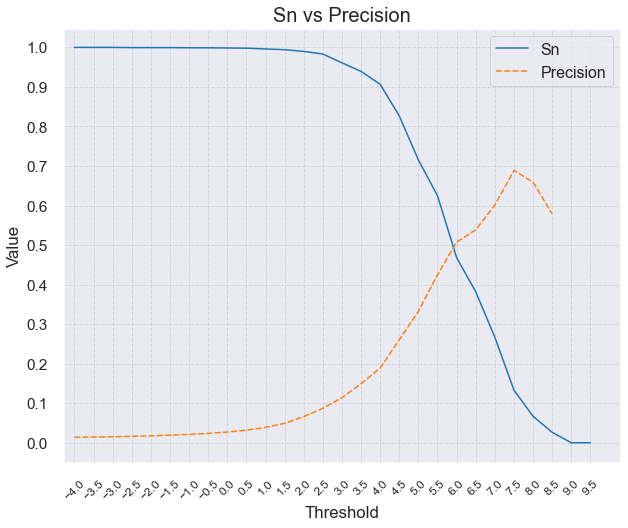

In [73]:
# plt.plot(list(threshold_range),,label="Sn",color='blue',lw=1.5,)
# plt.plot(ldf_all_threshold ist(threshold_range),,label="Sp",color='red',lw=1.5)

def draw_tendancy(df_all_threshold,cols=[]):
    sns.set_context("poster",font_scale=0.7)
    # sns.set_style("ticks")
    sns.despine()
    f,ax = plt.subplots(figsize=(10,8))
    sns.set(style="darkgrid") # sns.set(style="white")
    sns.lineplot(data=[df_all_threshold[col] for col in cols],palette="tab10",ax = ax)
    # ax = sns.lineplot(x="Threshold",y="Precision",data=df_all_threshold,palette="tab10")
    plt.xticks( np.arange(-4, 10,0.5),rotation=45,fontsize=12)
    ax.set_yticks( np.arange(0, 1.1, 0.1))
    plt.xlim([-4.3,10.3])
    ax.grid(True,linestyle = "-.",color = 'gray' ,linewidth = '0.5',alpha=0.4)
    ax.set_ylabel("Value")
    ax.legend(labels=cols,fontsize=16)
    if len(cols) == 2:
        plt.title(f"{cols[0]} vs {cols[1]}",fontsize=20)
        plt.savefig(f"predict/{cols[0]} vs {cols[1]}.png",dpi=400)
    elif len(cols) == 1:
        plt.title(f"{cols[0]}",fontsize=20)
        plt.savefig(f"predict/{cols[0]}.png",dpi=400)  
draw_tendancy(df_all_threshold,cols=["Sn","Precision"])

<Figure size 432x288 with 0 Axes>

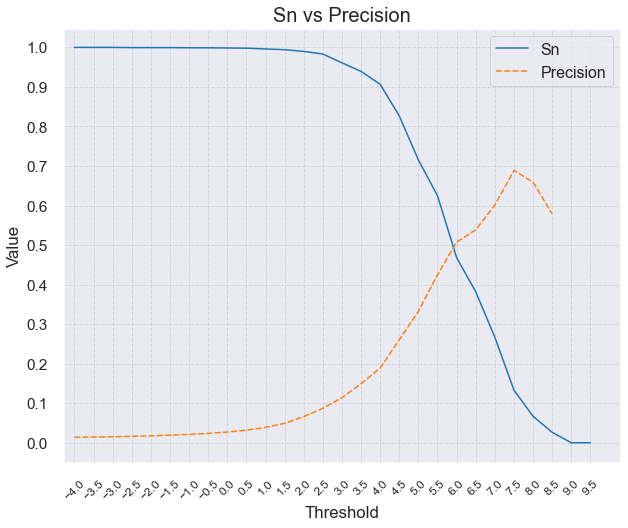

In [81]:
draw_tendancy(df_all_threshold,cols=["Sn","Precision"])

In [75]:
df_TPR_FPR=df_all_threshold["Sn"]-df_all_threshold["FPR"]
df_TPR_FPR.idxmax()

1.5

In [79]:
df_TPR_FPR

0.97263303132825

<Figure size 432x288 with 0 Axes>

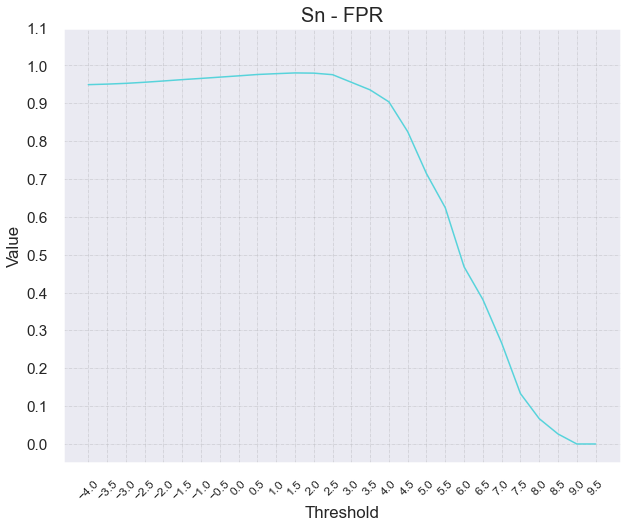

In [82]:

sns.set_context("poster",font_scale=0.7)
# sns.set_style("ticks")
sns.despine()
f,ax = plt.subplots(figsize=(10,8))
sns.set(style="darkgrid") # sns.set(style="white")
sns.lineplot(data=df_TPR_FPR,color="#57d3db",ax = ax)
# ax = sns.lineplot(x="Threshold",y="Precision",data=df_all_threshold,palette="tab10")
plt.xticks( np.arange(-4, 10,0.5),rotation=45,fontsize=12)
ax.set_yticks( np.arange(0, 1.2, 0.1))
ax.grid(True,linestyle = "-.",color = 'gray' ,linewidth = '0.5',alpha=0.4)
ax.set_ylabel("Value")
# ax.legend(labels=["Sn+Precision"],fontsize=16)
plt.title("Sn - FPR",fontsize=20)
plt.savefig(f"predict/Sn -FPR-left{left}-right{right}.png",dpi=400)

In [83]:
df_eval=df_all_threshold["Sn"]+df_all_threshold["Precision"]

<Figure size 432x288 with 0 Axes>

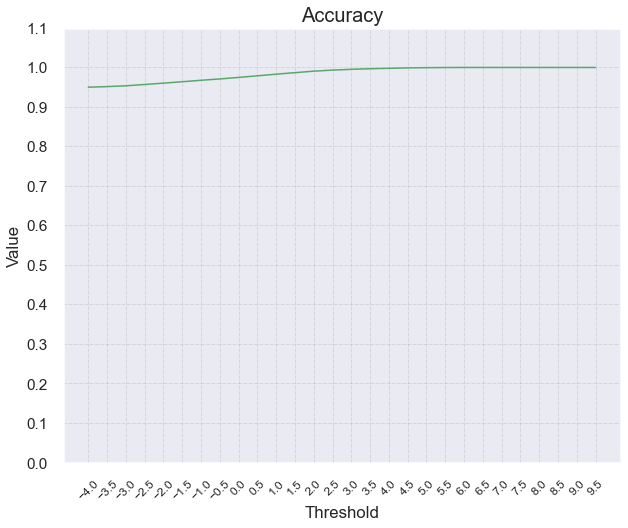

In [85]:
sns.set_context("poster",font_scale=0.7)
# sns.set_style("ticks")
sns.despine()
f,ax = plt.subplots(figsize=(10,8))
sns.set(style="darkgrid") # sns.set(style="white")
sns.lineplot(data=df_all_threshold["Acc"],color="g",ax = ax)
# ax = sns.lineplot(x="Threshold",y="Precision",data=df_all_threshold,palette="tab10")
plt.xticks( np.arange(-4, 10,0.5),rotation=45,fontsize=12)
ax.set_yticks( np.arange(0, 1.2, 0.1))
ax.grid(True,linestyle = "-.",color = 'gray' ,linewidth = '0.5',alpha=0.4)
ax.set_ylabel("Value")
# ax.legend(labels=["Sn+Precision"],fontsize=16)
plt.title("Accuracy",fontsize=20)
plt.savefig(f"predict/Acc-left{left}-right{right}.png",dpi=400)

<Figure size 432x288 with 0 Axes>

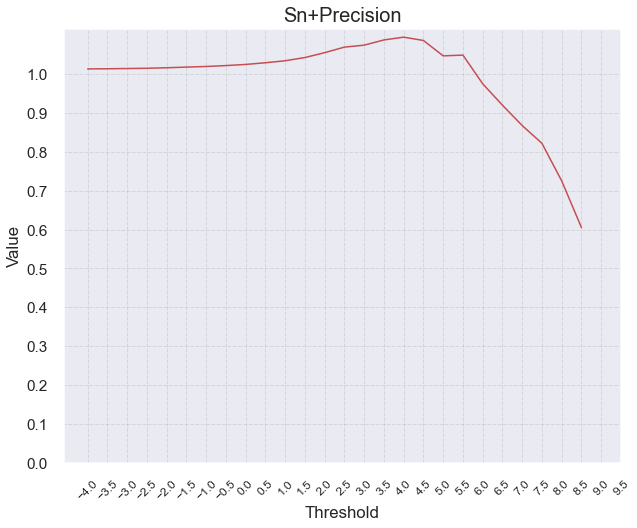

In [86]:
sns.set_context("poster",font_scale=0.7)
# sns.set_style("ticks")
sns.despine()
f,ax = plt.subplots(figsize=(10,8))
sns.set(style="darkgrid") # sns.set(style="white")
sns.lineplot(data=df_eval,color="r",ax = ax)
# ax = sns.lineplot(x="Threshold",y="Precision",data=df_all_threshold,palette="tab10")
plt.xticks( np.arange(-4, 10,0.5),rotation=45,fontsize=12)
ax.set_yticks( np.arange(0, 1.1, 0.1))
ax.grid(True,linestyle = "-.",color = 'gray' ,linewidth = '0.5',alpha=0.4)
ax.set_ylabel("Value")
# ax.legend(labels=["Sn+Precision"],fontsize=16)
plt.title("Sn+Precision",fontsize=20)
plt.savefig(f"predict/Sn+Precision-left{left}-right{right}.png",dpi=400)

In [87]:
TPR= list(df_all_threshold["Sn"])
FPR = list(df_all_threshold["FPR"])

阈值1.5的时候，TPR-FPR最大！

In [88]:
eva=df_all_threshold["Sn"]-df_all_threshold["FPR"]
eva.max() # 获取最大值
eva.idxmax() # series 获取最大索引

1.5

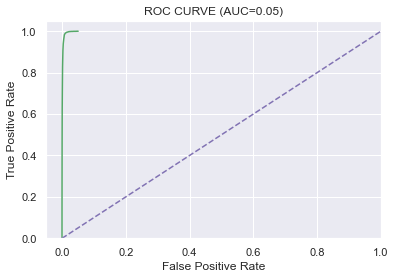

In [89]:
from sklearn.metrics import roc_curve,auc
#AUC值计算
AUC=auc(FPR,TPR)
#ROC曲线绘制
plt.figure()
plt.title('ROC CURVE (AUC={:.2f})'.format(AUC))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.plot(FPR,TPR,color='g')
plt.plot([0, 1], [0, 1], color='m', linestyle='--')
# plt.show()
plt.savefig(f"predict/WAM_ROC-left{left}-right{right}.png",dpi=400)

In [90]:

df_all_threshold["Sn"] =df_all_threshold["Sn"] .apply(lambda x: format(x, '.2%')) 
df_all_threshold["Sp"] =df_all_threshold["Sp"] .apply(lambda x: format(x, '.2%')) 
df_all_threshold["Precision"] =df_all_threshold["Precision"] .apply(lambda x: format(x, '.2%')) 
df_all_threshold["FPR"] =df_all_threshold["FPR"] .apply(lambda x: format(x, '.2%')) 
df_all_threshold["Acc"] =df_all_threshold["Acc"] .apply(lambda x: format(x, '.2%')) 


In [91]:
df_all_threshold.to_csv("predict/All_Threshold_info(%).csv")

In [92]:
# i=1
# threshold=-4
# TP_count = 0
# FP_count = 0
# FN_count = 0
# predict_count = 0
# seq= test_seq_list[i][3000:3200]
# seq_length = len(seq)
# scores = []
# predict_sites = []
# positive_sites = []
# negative_sites = []
# for pos in  range(seq_length-signal_num):
#     signal = seq[pos:pos+signal_num]
#     no_known =pattern.search(signal)
#     if no_known:
#         break
#     else:
#         s=cal_WAM(signal)
#         predict_count +=1
#         print(s)
#         if s > threshold:
# #             scores.append(s)
#             predict_site= pos+4
#             predict_sites.append(predict_site)
#             if predict_site in test_donor_list[i]:
#                 TP_count +=1
#                 positive_sites.append(predict_site)
#             else:
#                 FP_count +=1
#                 negative_sites.append(predict_site)
# print(TP_count)
# print(FP_count)
# print(seq_length)
# print(test_donor_list[i])


In [ ]:
print()